Training a Recurrent Neural Network on Google Colab TPU
----

# Setup

In [2]:
%load_ext autoreload
%autoreload 2

## Imports

In [2]:
import sys
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from typing import Tuple, Union, List
from sklearn.base import BaseEstimator, TransformerMixin, ClassifierMixin
# sys.path.append("../src")

2023-10-18 18:30:52.065845: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-10-18 18:30:52.111032: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-10-18 18:30:52.111074: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-10-18 18:30:52.111102: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-10-18 18:30:52.119090: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-10-18 18:30:52.120191: I tensorflow/core/platform/cpu_feature_guard.cc:182] This Tens

## Getting data from Drive

# Preprocessing

## Transformer classes

In [ ]:
def prepend_dir(filename):
    """
    Prepends `../data/processed/` to the filename
    """
    return '../data/processed/' + filename


def convert_multicat(df: pd.DataFrame, colname: str, copy:bool=True) -> Tuple[pd.DataFrame, List[str]]:
    '''(Optionally copies `df` and) converts the categorical column `colname` into dummies. Allows for membership in multiple categories separated by a single comma, e.g. entry "a,b" will be converted into `True` for columns `a` and `b`'''
    if copy:
        dummy_df = df.copy()
    else:
        dummy_df = df
    cats = set()
    for entry in dummy_df[colname].dropna().unique().tolist():
        for cat in entry.split(','):
            cats.add(cat)
    cats = list(cats)
    for cat in cats:
        dummy_df[cat] = dummy_df[colname].str.contains(cat).fillna(False)
    dummy_df.drop(columns=colname, inplace=True)

    return dummy_df, cats



class MakeDummies(BaseEstimator, TransformerMixin):
    """Transforms categorical columns into dummies. Can handle multi-category columns"""
    def __init__(self, multicat_col: str, drop_first=True, dummy_cols:Union[List[str], str]='auto') -> None:
        super().__init__()
        self.multicat_col = multicat_col
        self.drop_first = drop_first
        self.dummy_cols= dummy_cols
    
    def fit(self, X, y=None):
        _, self.cats = convert_multicat(X, self.multicat_col)
        return self
    
    def fit_transform(self, X, y=None):
        dummy_df, self.cats = convert_multicat(X, self.multicat_col)
        dummy_df = pd.get_dummies(dummy_df, drop_first=self.drop_first)
        return dummy_df
    
    def transform(self, X, y=None):
        dummy_df = X.copy()
        for cat in self.cats:
            dummy_df[cat] = dummy_df[self.multicat_col].str.contains(cat).fillna(False)
        dummy_df.drop(columns=self.multicat_col, inplace=True)
        dummy_df = pd.get_dummies(dummy_df, drop_first=self.drop_first)

        return dummy_df



class MCCRates(BaseEstimator, TransformerMixin):
    """Transforms MCC codes into average fraud rates, based on saved data or a specific training set. Note: only accepts data frames"""
    
    mcc_rates_file = prepend_dir('mcc_rates.csv')
    
    def __init__(self, use_saved=True) -> None:
        super().__init__()
        self.use_saved = use_saved
        self.mcc_rates = None

    def fit(self, X, y=None):
        if self.use_saved:
            if self.mcc_rates is None:
                self.mcc_rates = pd.read_csv(self.mcc_rates_file, index_col=0)
        else:
            self.mcc_rates = (
                X.copy()
                .groupby('mcc')
                .agg('mean')
                .rename({'mean':'mcc_fraud_rate'}, axis=1)
            )
        return self
    
    def fit_transform(self, X, y=None):
        self.fit(X)
        return self.transform(X)

    def transform(self, X, y=None):
        X_transformed = X.merge(self.mcc_rates, how='left', left_on='mcc', right_index=True)
        X_transformed.drop(columns='mcc', inplace=True)
        return X_transformed

## Creating the datasets

In [4]:
# load balanced training data and test data
training_data = pd.read_csv(prepend_dir('tx_train_set.csv'), index_col=0)
testing_data = pd.read_csv(prepend_dir('tx_test.csv'), index_col=0)

mcc_converter = MCCRates()
dummy_converter = MakeDummies('errors')

# y_train = training_data.is_fraud.copy()
# X_train = mcc_converter.fit_transform(training_data.drop(columns='is_fraud'))
X_train = mcc_converter.fit_transform(training_data)
X_train = dummy_converter.fit_transform(X_train)

# y_test = testing_data.is_fraud.copy()
# X_test = mcc_converter.transform(testing_data.drop(columns='is_fraud'))
# X_test = dummy_converter.transform(X_test)
# X_train.shape, X_test.shape, y_train.shape, y_test.shape

In [5]:
X_train.head().T

,2001,2005,2018,2028,2031
user,22,22,22,22,22
card,0,0,0,0,0
amount,149.42,2.32,61.4,41.87,12.59
is_fraud,True,True,True,True,True
has_chip,True,True,True,True,True
cards_issued,2,2,2,2,2
credit_limit,4488.0,4488.0,4488.0,4488.0,4488.0
latitude,41.47,41.47,41.47,41.47,41.47
longitude,-81.67,-81.67,-81.67,-81.67,-81.67
per_capita_income_zipcode,19524.0,19524.0,19524.0,19524.0,19524.0


In [6]:
max_length = X_train.groupby('user')['amount'].agg('count').max()
D = X_train.shape[1]
train_users = training_data.user.unique()
print(len(train_users), max_length, D)

217 47363 38


Keras RNNs take 3-d arrays of shape $(N, L, D)$, where $L$ is a fixed sequence length. Observations with shorter sequences should be "padded" to the right with 0 vectors. These can then be processed by a `Mask(mask_value=0.0, input_shape=(L,D))` layer, which will output a boolean matrix of size $(N,L)$ indicating which sequence entries are real observations. There is a utility function for padding, but only seems to work with 1d sequences.

In [7]:
X_seq_train = np.zeros((len(train_users), max_length, D-2))
y_seq_train = np.zeros((len(train_users), max_length, 1))
X_seq_train.shape

(217, 47363, 36)

In [8]:
for i, user in enumerate(train_users):
    seq_length = len(X_train[X_train.user==user])
    X_seq_train[i,:seq_length,:] = X_train[X_train.user==user].drop(columns=['user', 'is_fraud']).copy()
    y_seq_train[i,:seq_length,0] = X_train[X_train.user==user].is_fraud.copy()
y_train = y_seq_train.reshape(-1)

In [9]:
seq_length, num_cols = X_seq_train.shape[1:]

How to get predictions for the whole sequence? Gedion has example where this is achieved by a dense layer with width matching the sequence to be predicted. However, this creates a LOT of weights.

In [10]:
y_seq_train.shape, X_seq_train.shape

((217, 47363, 1), (217, 47363, 36))

# Model setup

## TPU strategy

In [ ]:
tf.keras.backend.clear_session()

resolver = tf.distribute.cluster_resolver.TPUClusterResolver('grpc://' + os.environ['COLAB_TPU_ADDR'])
# or: tf.distribute.cluster_resolver.TPUClusterResolver() # TPU detection
tf.config.experimental_connect_to_cluster(resolver)

# This is the TPU initialization code that has to be at the beginning.
tf.tpu.experimental.initialize_tpu_system(resolver)
print("All devices: ", tf.config.list_logical_devices('TPU'))

strategy = tf.distribute.experimental.TPUStrategy(resolver)

In [11]:
def create_model(seq_length, num_cols, dense_width=1000, lstm_width=1000):
    rnn = keras.models.Sequential()

    rnn.add(keras.layers.Masking(input_shape=(seq_length, num_cols)))

    feature_extraction = keras.layers.Dense(dense_width, activation='relu')
    rnn.add(keras.layers.TimeDistributed(feature_extraction))

    rnn.add(keras.layers.LSTM(lstm_width, return_sequences=True))

    post_rnn = keras.layers.Dense(dense_width, activation='relu')
    rnn.add(keras.layers.TimeDistributed(post_rnn))

    output_layer = keras.layers.Dense(1, activation='sigmoid')
    rnn.add(keras.layers.TimeDistributed(output_layer))

    rnn.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=['recall']
    )
    return rnn



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 masking (Masking)           (None, 47363, 36)         0         
                                                                 
 time_distributed (TimeDist  (None, 47363, 50)         1850      
 ributed)                                                        
                                                                 
 lstm (LSTM)                 (None, 47363, 25)         7600      
                                                                 
 time_distributed_1 (TimeDi  (None, 47363, 50)         1300      
 stributed)                                                      
                                                                 
 time_distributed_2 (TimeDi  (None, 47363, 1)          51        
 stributed)                                                      
                                                        

# Training

In [ ]:
with strategy.scope():
    rnn = create_model(seq_length, num_cols)

print(rnn.summary())
training_history = rnn.fit(
    X_seq_train, 
    y_seq_train, 
    epochs=10,
)

rnn.save_weights('./fraud_prediction_rnn.h5', overwrite=True)

In [12]:
y_pred = rnn.predict(X_seq_train).reshape(-1)

7/7 [==============================] - 48s 7s/step


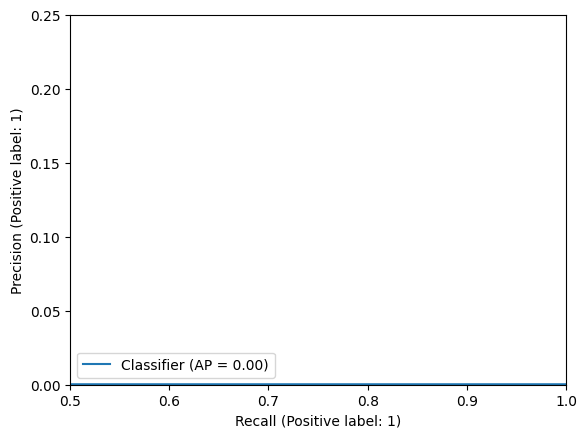

In [26]:
from sklearn.metrics import PrecisionRecallDisplay
p_r_curve = PrecisionRecallDisplay.from_predictions(y_train, y_pred)
plt.axis([0.5, 1., 0., 0.25]);

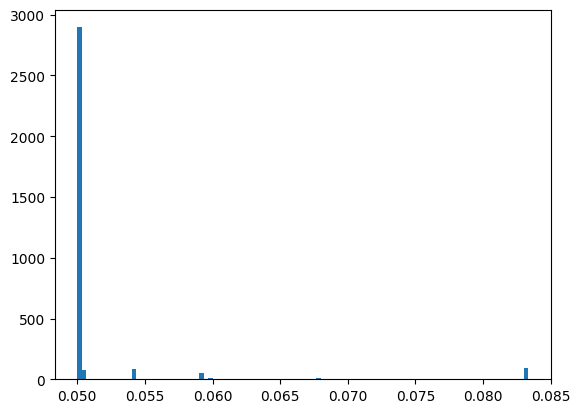

In [22]:
plt.hist(y_pred[y_train==1], bins=100);

In [27]:
np.sum(y_train)

3228.0